### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

Using TensorFlow backend.


In [2]:
# Defining hyperparameters
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5 # Per kilometer fuel and other costs
R = 9 # per kilometer revenue from a passenger

#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
states_track = collections.defaultdict(dict)
def initialise_tracking_states():
    sample_q_values = [((3,0,2),(3,1)),((1,6,3),(2,3)),((2,2,2),(3,2)),((3,10,6),(3,4)),((0,20,3),(1,4)), ((1,23,3),(1,4))]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        states_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

In [5]:
initialise_tracking_states() # initialised all the state-action pairs tracked

In [6]:
# This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence

def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            Q = agent.prediction([action], state)
            states_track[state][action].append(Q)          

In [7]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [8]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        # Define size of state and action
        self.state_size = m+t+d
        self.action_size = m*(m-1) + 1
        self.action_space = [[i,j] for i in range(m) for j in range(m) if i!=j or i==0]

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate = 0.001        
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.0003
        self.epsilon_min = 0.00000001
        self.batch_size = 32        
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       
        model.add(Dense(200, input_dim = 46,activation ='relu'))
        model.add(Dense(150,activation ='relu'))
        model.add(Dense(100,activation ='relu'))
        model.add(Dense(1,activation ='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary
        return model

    def prediction(self, action, state):
        X_test = np.zeros((len(action), 46))
        for i in range(len(action)):
            dummy = env.state_encod_arch2(state, action[i])
            X_test[i,:] = dummy
        prediction = self.model.predict(X_test)
        prediction = prediction.reshape(len(action))
        return prediction


    def get_action(self, state, episode):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment     
        poss_actions_index, poss_actions = env.requests(state)
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)
        
        if np.random.rand() <= epsilon: # Exploration: randomly choosing and action      
            action_index = np.random.choice(poss_actions_index)
            action = self.action_space[action_index]
        else: #Exploitation: this gets the action corresponding to max q-value of current state
            q_value = self.prediction(poss_actions, state)
            action_index = np.argmax(q_value)
            action = poss_actions[action_index]
        return action, epsilon
        
    

    def append_sample(self, state, action, reward, next_state, terminal_state):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal_state))
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
  

        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        update_input = np.zeros((self.batch_size, 46))
        update_output = np.zeros((self.batch_size, self.action_size))

        actions, rewards, terminal_states = [], [], []

        
        
        for i in range(self.batch_size):
            
            state, action, reward, next_state, terminal_state = mini_batch[i]
            
            actions.append(self.action_space.index(action))
            rewards.append(reward)
            terminal_states.append(terminal_state)
            

            update_input[i] = env.state_encod_arch2(state, action)
            update_output[i,:]= self.prediction(self.action_space, next_state)
        
        target = np.zeros((self.batch_size))
        # get your target Q-value on the basis of terminal state
        for i in range(self.batch_size):
            if terminal_states[i]:
                #print(True)
                target[i] = rewards[i]
                
            else:
                target[i] = rewards[i] + self.discount_factor * (np.amax(update_output[i]))

        self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                           
                
                # Write your code from here
                # 1. Predict the target from earlier model
                
                
                # 2. Get the target for the Q-network
                
                
                #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair

                
                
        # 4. Fit your model and track the loss values

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [9]:
Episodes = 22000

### DQN block

In [10]:
# Importing the environment
from Env import CabDriver

In [11]:
# Initialising the environment
env = CabDriver()
# get size of state and action from environment
state_size = len(env.state_space)
action_size = len(env.action_space)

# agent needs to be initialised outside the loop since the DQN
# network will be initialised along with the agent
agent = DQNAgent(state_size, action_size)

# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



episode: 0   score: -208.0   memory length: 140   epsilon: 1.0
episode: 25   score: -36.0   memory length: 2000   epsilon: 0.9925280548938579
episode: 50   score: 70.0   memory length: 2000   epsilon: 0.9851119397519432
episode: 75   score: -183.0   memory length: 2000   epsilon: 0.9777512374158239
episode: 100   score: -128.0   memory length: 2000   epsilon: 0.9704455338440529
episode: 125   score: -83.0   memory length: 2000   epsilon: 0.9631944180888776
episode: 150   score: -32.0   memory length: 2000   epsilon: 0.9559974822731252
episode: 175   score: -56.0   memory length: 2000   epsilon: 0.948854321567258
episode: 200   score: -108.0   memory length: 2000   epsilon: 0.9417645341666034
episode: 225   score: 36.0   memory length: 2000   epsilon: 0.9347277212687504
episode: 250   score: -162.0   memory length: 2000   epsilon: 0.927743487051118
episode: 275   score: -252.0   memory length: 2000   epsilon: 0.9208114386486902
episode: 300   score: 160.0   memory length: 2000   epsilo

episode: 2500   score: 591.0   memory length: 2000   epsilon: 0.47236655801734917
episode: 2525   score: 819.0   memory length: 2000   epsilon: 0.4688370610652907
episode: 2550   score: 791.0   memory length: 2000   epsilon: 0.4653339363209741
episode: 2575   score: 904.0   memory length: 2000   epsilon: 0.46185698673270864
episode: 2600   score: 660.0   memory length: 2000   epsilon: 0.45840601672116343
episode: 2625   score: 553.0   memory length: 2000   epsilon: 0.4549808321683652
episode: 2650   score: 807.0   memory length: 2000   epsilon: 0.4515812404067799
episode: 2675   score: 904.0   memory length: 2000   epsilon: 0.4482070502084744
episode: 2700   score: 676.0   memory length: 2000   epsilon: 0.4448580717743605
episode: 2725   score: 846.0   memory length: 2000   epsilon: 0.4415341167235181
episode: 2750   score: 579.0   memory length: 2000   epsilon: 0.4382349980825993
episode: 2775   score: 693.0   memory length: 2000   epsilon: 0.4349605302753106
episode: 2800   score: 11

episode: 5025   score: 1206.0   memory length: 2000   epsilon: 0.22146295160897447
episode: 5050   score: 1153.0   memory length: 2000   epsilon: 0.21980819264967988
episode: 5075   score: 1089.0   memory length: 2000   epsilon: 0.21816579795861663
episode: 5100   score: 1349.0   memory length: 2000   epsilon: 0.21653567515065042
episode: 5125   score: 1372.0   memory length: 2000   epsilon: 0.21491773253094335
episode: 5150   score: 1095.0   memory length: 2000   epsilon: 0.2133118790897965
episode: 5175   score: 1145.0   memory length: 2000   epsilon: 0.21171802449753047
episode: 5200   score: 1413.0   memory length: 2000   epsilon: 0.21013607909940404
episode: 5225   score: 1260.0   memory length: 2000   epsilon: 0.20856595391057153
episode: 5250   score: 567.0   memory length: 2000   epsilon: 0.2070075606110771
episode: 5275   score: 994.0   memory length: 2000   epsilon: 0.20546081154088675
episode: 5300   score: 1084.0   memory length: 2000   epsilon: 0.20392561969495734
episode:

episode: 7525   score: 1116.0   memory length: 2000   epsilon: 0.10461169628771591
episode: 7550   score: 1314.0   memory length: 2000   epsilon: 0.10383004350249662
episode: 7575   score: 1557.0   memory length: 2000   epsilon: 0.10305423118403892
episode: 7600   score: 1591.0   memory length: 2000   epsilon: 0.1022842156926954
episode: 7625   score: 1294.0   memory length: 2000   epsilon: 0.10151995371489163
episode: 7650   score: 1323.0   memory length: 2000   epsilon: 0.10076140226068979
episode: 7675   score: 1533.0   memory length: 2000   epsilon: 0.10000851866137064
episode: 7700   score: 1295.0   memory length: 2000   epsilon: 0.09926126056703317
episode: 7725   score: 1268.0   memory length: 2000   epsilon: 0.0985195859442125
episode: 7750   score: 1293.0   memory length: 2000   epsilon: 0.09778345307351563
episode: 7775   score: 1518.0   memory length: 2000   epsilon: 0.09705282054727445
episode: 7800   score: 1385.0   memory length: 2000   epsilon: 0.09632764726721664
episod

episode: 10000   score: 1484.0   memory length: 2000   epsilon: 0.04978707786999328


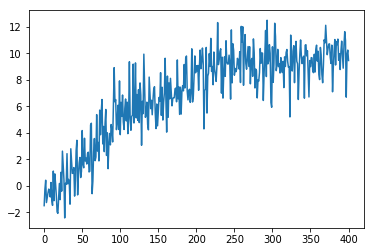

episode: 10025   score: 1035.0   memory length: 2000   epsilon: 0.04941507162815284
episode: 10050   score: 1880.0   memory length: 2000   epsilon: 0.049045844996558396
episode: 10075   score: 1716.0   memory length: 2000   epsilon: 0.04867937720611454
episode: 10100   score: 1321.0   memory length: 2000   epsilon: 0.04831564764291141
episode: 10125   score: 1317.0   memory length: 2000   epsilon: 0.04795463584706521
episode: 10150   score: 1323.0   memory length: 2000   epsilon: 0.047596321511567195
episode: 10175   score: 1474.0   memory length: 2000   epsilon: 0.04724068448114156
episode: 10200   score: 1494.0   memory length: 2000   epsilon: 0.04688770475111156
episode: 10225   score: 1602.0   memory length: 2000   epsilon: 0.04653736246627427
episode: 10250   score: 1304.0   memory length: 2000   epsilon: 0.04618963791978384
episode: 10275   score: 1466.0   memory length: 2000   epsilon: 0.045844511552042826
episode: 10300   score: 1782.0   memory length: 2000   epsilon: 0.0455019

episode: 12475   score: 1710.0   memory length: 2000   epsilon: 0.023694801806280107
episode: 12500   score: 1539.0   memory length: 2000   epsilon: 0.023517755620831658
episode: 12525   score: 1737.0   memory length: 2000   epsilon: 0.02334203231477535
episode: 12550   score: 1602.0   memory length: 2000   epsilon: 0.02316762200362891
episode: 12575   score: 1244.0   memory length: 2000   epsilon: 0.022994514876766323
episode: 12600   score: 1519.0   memory length: 2000   epsilon: 0.022822701196866066
episode: 12625   score: 1548.0   memory length: 2000   epsilon: 0.022652171299363356
episode: 12650   score: 1370.0   memory length: 2000   epsilon: 0.022482915591906485
episode: 12675   score: 1548.0   memory length: 2000   epsilon: 0.022314924553817266
episode: 12700   score: 1314.0   memory length: 2000   epsilon: 0.022148188735555536
episode: 12725   score: 1575.0   memory length: 2000   epsilon: 0.021982698758187546
episode: 12750   score: 1215.0   memory length: 2000   epsilon: 0.0

KeyboardInterrupt: 

In [12]:
for episode in range(Episodes):

    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False

    #Call the DQN agent
    
    
    while not terminal_state:
        
        action, epsilon = agent.get_action(state, episode)
        reward = env.reward_func(state, action, Time_matrix)
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # every time step do the training
        agent.train_model()
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state and episode % 25 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode, "  score:", tot_reward, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
            
            
    if episode % 200 == 0:
            agent.save("./cab_driver.h5")

    if episode % 25 == 0:   #every 2000th episode
        save_obj(avg_reward,'Rewards')   
        save_tracking_states()
        save_obj(states_track,'States_tracked')   
        
    
    if episode % 10000 ==0 and episode !=0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()
        
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        # 4. Train the model by calling function agent.train_model
        # 5. Keep a track of rewards, Q-values, loss
        

### Tracking Convergence

In [ ]:
# Plotting average rewards
# x-values = 40000 episodes tracked after every 25th episode
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.ylabel("Average Reward")
plt.show()

In [ ]:
# Plotting total rewards
plt.plot(list(range(len(total_reward))), total_reward)
plt.ylabel("Total reward")
plt.show()

## Checking Q-values

In [ ]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(len(states_track[(3,0,2)][(3,1)])))
plt.subplot(241)
plt.plot(xaxis,np.asarray(states_track[(3,0,2)][(3,1)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(1,6,3)][(2,3)])))
plt.subplot(242)
plt.plot(xaxis,np.asarray(states_track[(1,6,3)][(2,3)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(2,2,2)][(3,2)])))
plt.subplot(243)
plt.plot(xaxis,np.asarray(states_track[(2,2,2)][(3,2)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(3,10,6)][(3,4)])))
plt.subplot(244)
plt.plot(xaxis,np.asarray(states_track[(3,10,6)][(3,4)]))
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(len(states_track[(0,20,3)][(1,4)])))
plt.subplot(245)
plt.plot(xaxis,np.asarray(states_track[(0,20,3)][(1,4)]))
plt.ylabel("Q-value")
plt.show

#### Interpreting Q-values

In [ ]:
plt.figure(0, figsize=(16,7))

xaxis = np.asarray(range(500))
plt.subplot(241)
plt.plot(xaxis,np.asarray(states_track[(3,0,2)][(3,1)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(242)
plt.plot(xaxis,np.asarray(states_track[(1,6,3)][(2,3)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(243)
plt.plot(xaxis,np.asarray(states_track[(2,2,2)][(3,2)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(244)
plt.plot(xaxis,np.asarray(states_track[(3,10,6)][(3,4)])[-500:])
plt.ylabel("Q-value")
plt.show

xaxis = np.asarray(range(500))
plt.subplot(245)
plt.plot(xaxis,np.asarray(states_track[(0,20,3)][(1,4)])[-500:])
plt.ylabel("Q-value")
plt.show

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()